In [1]:
import numpy as np
import pandas as pd
from mplsoccer import Sbopen
from matplotlib import pyplot as plt
from mplsoccer import Pitch
from shapely.geometry import LineString
import jenkspy
import warnings
warnings.simplefilter(action="ignore")

# 1. Data Preparation
1. Stack all events/frames in EURO 2024
2. Make a easy-to-read index
3. Extract all passes

In [5]:
# get all EURO 2024 matches
parser = Sbopen()
matches = parser.match(competition_id=55, season_id=282)

In [6]:
# stack all matches
df_frame = pd.DataFrame()
df_visible = pd.DataFrame()
df_event = pd.DataFrame()

for i in range(matches.shape[0]):
    tmp_frame, tmp_visible = parser.frame(matches.iloc[i].match_id)
    tmp_event = parser.event(matches.iloc[i].match_id)[0]

    df_event = pd.concat([df_event, tmp_event])
    df_visible = pd.concat([df_visible, tmp_visible])
    df_frame = pd.concat([df_frame, tmp_frame])


In [7]:
df_event.reset_index(drop=True, inplace=True)
df_event['index'] = df_event.index

In [8]:
# make an easy-to-read index
id_index = df_event[['id', 'index']]
df_frame = df_frame.merge(id_index, how='inner', on='id')
df_visible = df_visible.merge(id_index, how='inner', on='id')

In [9]:
df_event.drop('id', axis=1, inplace=True)
df_frame.drop('id', axis=1, inplace=True)
df_visible.drop('id', axis=1, inplace=True)

In [10]:
# extract all passes from open-play
passes = df_event[df_event['type_name'] == 'Pass'][[
    'index','match_id', 'period', 'minute', 'second', 'duration', 'possession_team_name',
    'team_name', 'player_name', 'pass_recipient_name', 'end_x', 'end_y', 'x',
    'y', 'outcome_name', 'sub_type_name', 'pass_height_name', 'pass_length', 'pass_angle'
]]
passes_openplay = passes.loc[(passes['sub_type_name'].isna())
                             & (passes['outcome_name'] != 'Out') &
                             (passes['outcome_name'] != 'Unknown') &
                             (passes['outcome_name'] != 'Injury Clearance')]

passes_openplay.drop('sub_type_name', axis=1, inplace=True)

# 2. Identify Line-Breaking Passes

**LBP Definition**:

For the purposes of this analysis, a line-breaking pass is defined as a pass which not only intersects at least one of the opposition lines in a geometric sense, but also:

- Progresses the ball forward at least 10 metres(10.936 yards);
- Has a starting point which is at least 5 metres(5.468 yards) away from the point of intersection;
- Has an ending point of at least 2 metres(2.187 yards) beyond the deepest sitting player in the line.
- The receiver of the pass is not subject to pressure applied by any opposition player who was part of the broken line.

This definition eliminates passes that:
- Break the lines in a geometric sense, but are unlikely to result in a transition to the next attacking phase;
- Are extremely easy to complete, due to their proximity to the line that it penetrates.

> Reference: [Kuba Michalczyk. "How Impactful Are Line-Breaking Passes?" on Stats Perform](https://www.statsperform.com/resource/how-impactful-are-line-breaking-passes/)

In this case I only considered those **ground passes** because they are more align with the concept of Line-Breaking Passes in the tactical sense. Also it's more accurate when fitting Weibull Survival Model and StatsBomb has this `pass_height` data.

**Problems to tackle**:
- Some passes are intercepted so that we can't know whether they're meant to be line-breaking or not
- Not all 11 defensive player are in the frame
  - adjust the number of defensive line based on the number of def players in the frame(not done yet)

## 2.1 Deal With Incomplete Passes
Incomplete passes --> Intercepted

**Method:** Weibull Survival Model
> "Die" in a survival model means "Ball Intercepted" in this scenario

1. Extract all incomplete ground passes
   > High passes have a much longer length when intercepted, the heterogeneity will harm the fit of survival model. And only ground passes will be considered as line-breaking passes in this case.
2. Use the pass survived length to fit the Weibull Survival Model
3. Adjust for interception: Given the condition that the pass has already survived X meters
4. Calculate expected pass length
5. Predict the intented pass end coordinate

In [8]:
# 1. Extract all incomplete passes (ground pass only)
passes_openplay_incomplete = passes_openplay[passes_openplay['outcome_name']=='Incomplete']

In [9]:
passes_openplay_incomplete.groupby('pass_height_name').agg({'index':'count','pass_length':'mean'})

,index,pass_length
pass_height_name,,
Ground Pass,1857,13.447067
High Pass,2542,38.618197
Low Pass,1003,12.468379


In [10]:
passes_openplay_incomplete = passes_openplay_incomplete[passes_openplay_incomplete['pass_height_name']=='Ground Pass']

In [11]:
# 2. Use the pass survived length to fit the Weibull Survival Model
from scipy.stats import weibull_min
from scipy.optimize import minimize

observed_lengths = passes_openplay_incomplete['pass_length']

# Fit a Weibull Survival Model using pass_length
def weibull_neg_log_likelihood(params, data):
    k, lambd = params
    if k <= 0 or lambd <= 0:
        return np.inf  # Ensure valid parameters
    log_pdf = weibull_min.logpdf(data, c=k, scale=lambd)
    return -np.sum(log_pdf)

# Initial guesses for Weibull parameters
initial_params = [1.5, observed_lengths.mean()]

# Fit Weibull parameters using MLE
result = minimize(weibull_neg_log_likelihood,
                  initial_params,
                  args=(observed_lengths, ),
                  bounds=[(0.1, None), (0.1, None)])
k_fit, lambd_fit = result.x
print(f'Fitted Weibull parameters: k={k_fit:.2f}, lambda={lambd_fit:.2f}')

Fitted Weibull parameters: k=1.50, lambda=13.45


Conditional Expectation:
$$
\mathbb{E}[X \mid X > d_{\text{survived}}] = \frac{\int_{d_{\text{survived}}}^\infty x f(x; k, \lambda) \, dx}{P(X > d_{\text{survived}})}=\frac{\int_{d_{\text{survived}}}^\infty x f(x; k, \lambda) \, dx}{S(d_{\text{survived}})}
$$

where $f(x; k, \lambda)$ is the PDF of Weibull survival function, $S(x)=P({X>x})=1-F(x)$ is the survival function.

In [ ]:
# 3. Adjust for interception
from scipy.special import gammaincc, gamma

def conditional_expectation(d_survived, k, lambd):
    a = 1 + 1/k
    x = (d_survived/lambd)**k
    result = lambd * np.exp(x) * gammaincc(a, x) * gamma(a)
    return result

In [14]:
# 4. Calculate expected pass length
passes_openplay_incomplete['expected_pass_length'] = passes_openplay_incomplete['pass_length'].apply(lambda x: conditional_expectation(x, k_fit, lambd_fit))

In [15]:
def calculate_expected_end_coordinates(row):
    start_x = row['x']
    start_y = row['y']
    pass_angle = row['pass_angle']
    expected_pass_length = row['expected_pass_length']
    
    end_x = start_x + expected_pass_length * np.cos(pass_angle)
    end_y = start_y + expected_pass_length * np.sin(pass_angle)
    
    return pd.Series([end_x, end_y])

# Apply the function to the dataframe
passes_openplay_incomplete[['end_x', 'end_y']] = passes_openplay_incomplete.apply(calculate_expected_end_coordinates, axis=1)

## 2.2 Functions for Identifying a Line-Breaking Pass

### 2.2.1 Make Defensive Lines
- Use Jenks natural breaks clustering to form the defensive line
- Form three defensive lines(exclude the goalkeeper)

In [16]:
# label defensive lines
def label_def_lines(x, breaks):
    x_1, x_2, x_3, x_4 = breaks[0], breaks[1], breaks[2], breaks[3]
    if x <= x_2:
        return 1
    elif x > x_2 and x <= x_3:
        return 2
    else:
        return 3

In [17]:
# Make defensive lines
def make_defensive_lines(opp_frame):
    breaks = jenkspy.jenks_breaks(opp_frame['x'], n_classes=3)
    result = opponents['x'].apply(label_def_lines, args=(breaks, ))

    return result

### 2.2.2 Determine if the pass breaks a line(or meant to be)

In [18]:
# Determine the if the pass breaks at least one defensive line 
def break_which_line(def_line_group, pass_line):
    # Only proceed if the group has at least two points
    if len(def_line_group) > 1:
        # Create a LineString from the group's coordinates
        polyline = LineString(zip(def_line_group['x'], def_line_group['y']))

        # Check if the line intersects with this polyline, also return coordinates
        intersects = pass_line.intersects(polyline)

        if intersects:
            intersection = pass_line.intersection(polyline)
            if intersection.geom_type == 'Point':
                intersections = (intersection.x, intersection.y)
            elif intersection.geom_type == 'MultiPoint':
                intersections_list = list(intersection.geoms)
                intersections = [(point.x, point.y) for point in intersections_list][-1]
        else:
            intersections = None

    else:
        # If only 1 player forms a line, return false
        intersects = False
        intersections = None

    return intersects, intersections

In [19]:
# Determine if it is a line-breaking pass
def is_line_breaking(index):

    event = df_event[df_event['index'] == index]  # get event row
    x, y, end_x, end_y = event.iloc[0]['x'], event.iloc[0]['y'], event.iloc[0][
        'end_x'], event.iloc[0]['end_y']  # get pass route

    # retrieve the corresponding frame for the event
    frame = df_frame[df_frame['index'] == index]
    opponents = frame.loc[(frame['teammate'] == False) & (
        frame['keeper'] == False)]  # all opponents data prepared for clustering defensive line

    # if meet criteria 1 and pass is a ground pass
    if (end_x - x) > 10:
        # since there are some events that have no frame captured, label them as non-line-breaking passes
        try:
            # cluster the defensive lines
            breaks = jenkspy.jenks_breaks(opponents['x'], n_classes=3)
            opponents['def_line'] = opponents['x'].apply(label_def_lines, args=(breaks, ))

            # Re-order the opponents data by group so that defensive lines are drawn top down
            opponents = opponents.groupby('def_line').apply(
                lambda x: x.sort_values(by='y')).reset_index(drop=True)

            # identify if this pass geometrically breaks any defensive line
            pass_line = LineString([(x, y),
                                    (end_x, end_y)])  # form the pass line
            break_point_by_line = opponents.groupby('def_line').apply(
                lambda group: break_which_line(group, pass_line)).values

            # breakdown two parts of the output
            if_break = np.array([item[0] for item in break_point_by_line]).sum()
            break_points = [item[1] for item in break_point_by_line]
            if if_break > 1:  # break more than 1 line
                flag = True

            elif if_break == 1:  # break one line
                break_point = [item for item in break_points if item is not None][0]

                # meet criteria 2&3
                start2intersect = np.linalg.norm(
                        np.array([x, y]) - np.array(break_point))
                intersect2end = np.linalg.norm(
                        np.array(break_point) - np.array([end_x, end_y]))
                if start2intersect >= 5.4 and intersect2end >= 2.1:
                    flag = True
                else:
                    flag = False

            else:  # break no line
                flag = False
        except ValueError:
            flag = False

    else:
        flag = False

    return flag

### 2.2.3 Visualize a frame

In [20]:
# Plot a frame
def visualize_frame(event_index):
    if event_index in df_visible['index'].values:

        # retrieve the corrresponding frame for the event
        frame = df_frame[df_frame['index'] == event_index]
        opponents = frame.loc[(frame['teammate'] == False) & (
            frame['keeper'] == False)]  # all opponents data prepared for clustering defensive line
        
        x = df_visible[df_visible['index'] ==
                    event_index].visible_area.values[0][::2]
        y = df_visible[df_visible['index'] ==
                    event_index].visible_area.values[0][1::2]

        # plot the positions
        pitch = Pitch('statsbomb',
                    line_color='black',
                    positional=True,
                    positional_color='#eadddd',
                    shade_color='#f2f2f2')

        fig, ax = pitch.grid(grid_height=0.8,
                            title_height=0.01,
                            axis=False,
                            endnote_height=0.01,
                            title_space=0,
                            endnote_space=0)

        # plot all opponents with grey circles
        pitch.scatter(frame[frame['teammate'] == False].x,
                    frame[frame['teammate'] == False].y,
                    color='grey',
                    ax=ax['pitch'],
                    marker='o',
                    s=500)

        # plot all teammates with red circles
        pitch.scatter(frame[frame['teammate'] == True].x,
                    frame[frame['teammate'] == True].y,
                    color='red',
                    ax=ax['pitch'],
                    marker='o',
                    s=500)

        # plot the pass route
        pitch.arrows(df_event[df_event['index'] == event_index].x,
                    df_event[df_event['index'] == event_index].y,
                    df_event[df_event['index'] == event_index].end_x,
                    df_event[df_event['index'] == event_index].end_y,
                    color='tab:orange',
                    ax=ax['pitch'],
                    alpha=1,
                    width=3)

        # plot the visible area
        hull = pitch.convexhull(x, y)
        pitch.polygon(hull, ax=ax['pitch'], facecolor='cornflowerblue', alpha=0.3)

        # cluster the defensive lines
        breaks = jenkspy.jenks_breaks(opponents['x'], n_classes=3)
        opponents['def_line'] = opponents['x'].apply(label_def_lines, args=(breaks, ))

        # Re-order the opponents data by group so that defensive lines are drawn top down
        opponents = opponents.groupby('def_line').apply(
            lambda x: x.sort_values(by='y')).reset_index(drop=True)
            
        # Plot lines connecting players in each defensive line
        for def_line, group in opponents.groupby('def_line'):
            pitch.lines(group['x'].values[:-1],
                        group['y'].values[:-1],
                        group['x'].values[1:],
                        group['y'].values[1:],
                        ax=ax['pitch'],
                        color='blue',
                        lw=2.5)
    
    else:
        print('No frame captured')

## 2.3 Label all the Line-Breaking Passes

### 2.3.1 Test
First goal for Spain: Fabian Ruiz to Morata

The original live stream frame snipped from Youtube:
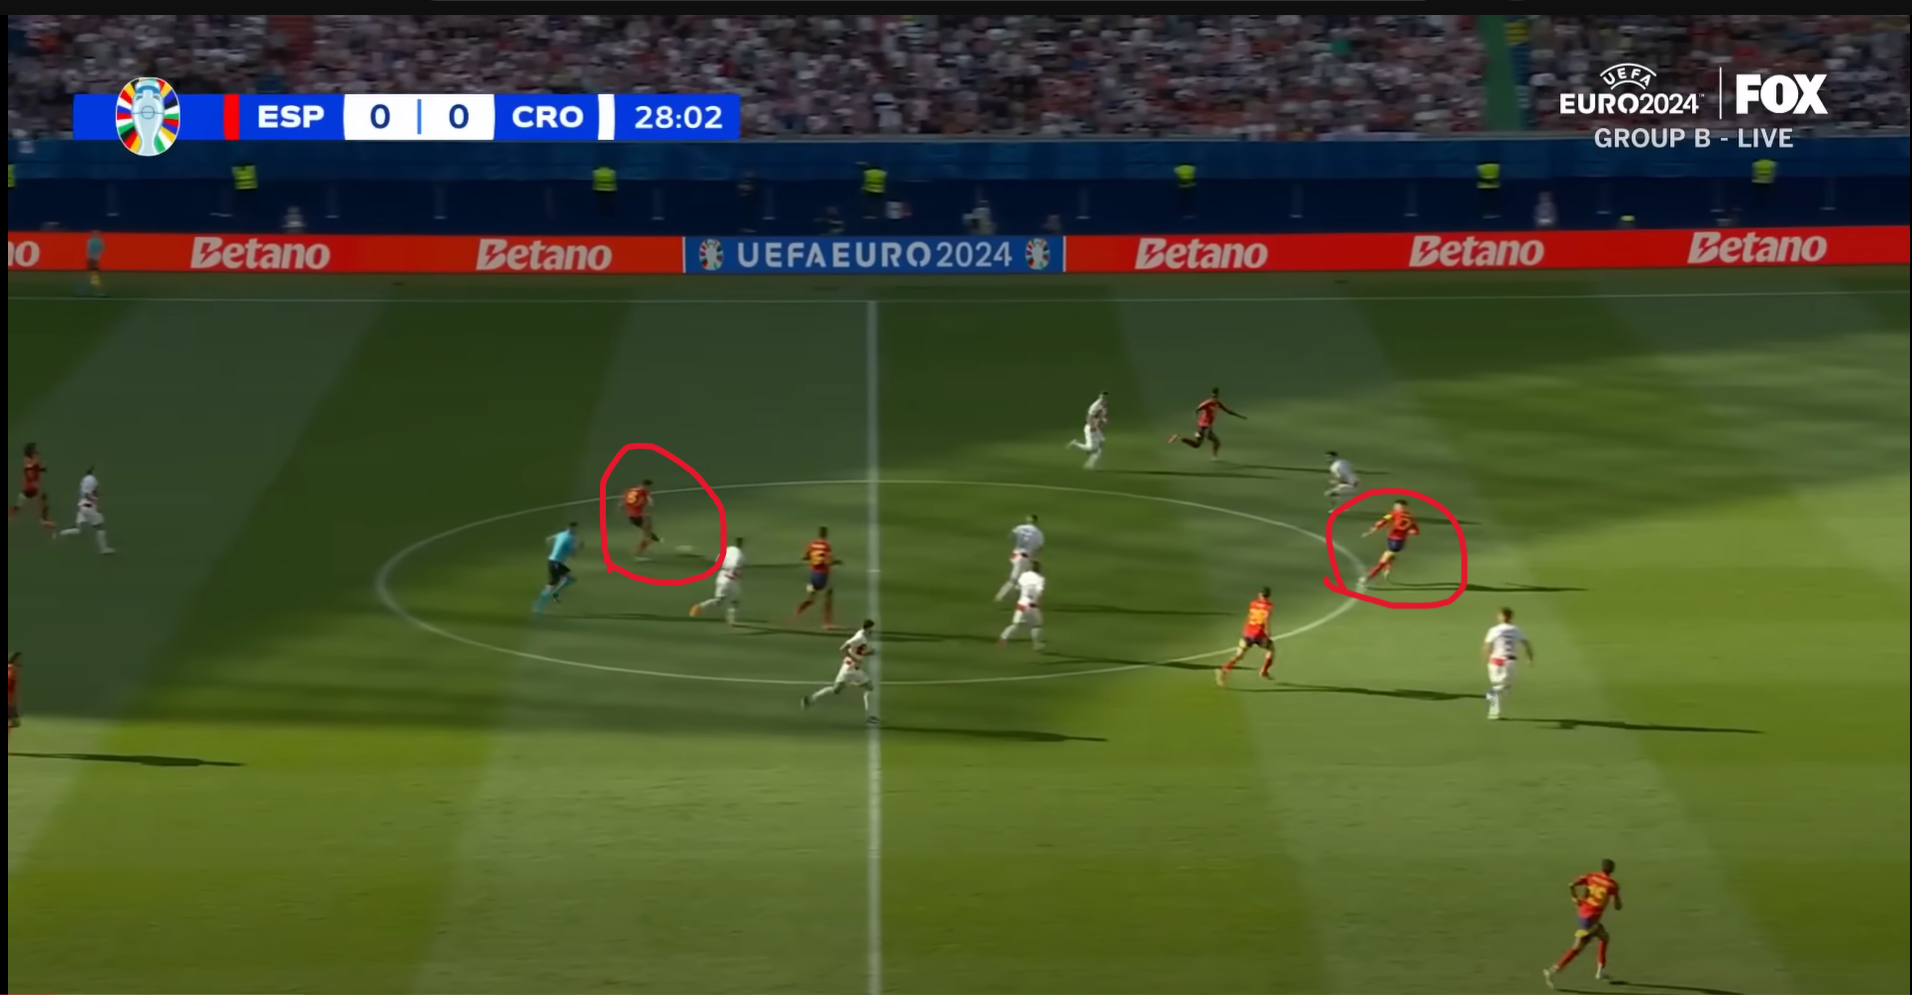

True


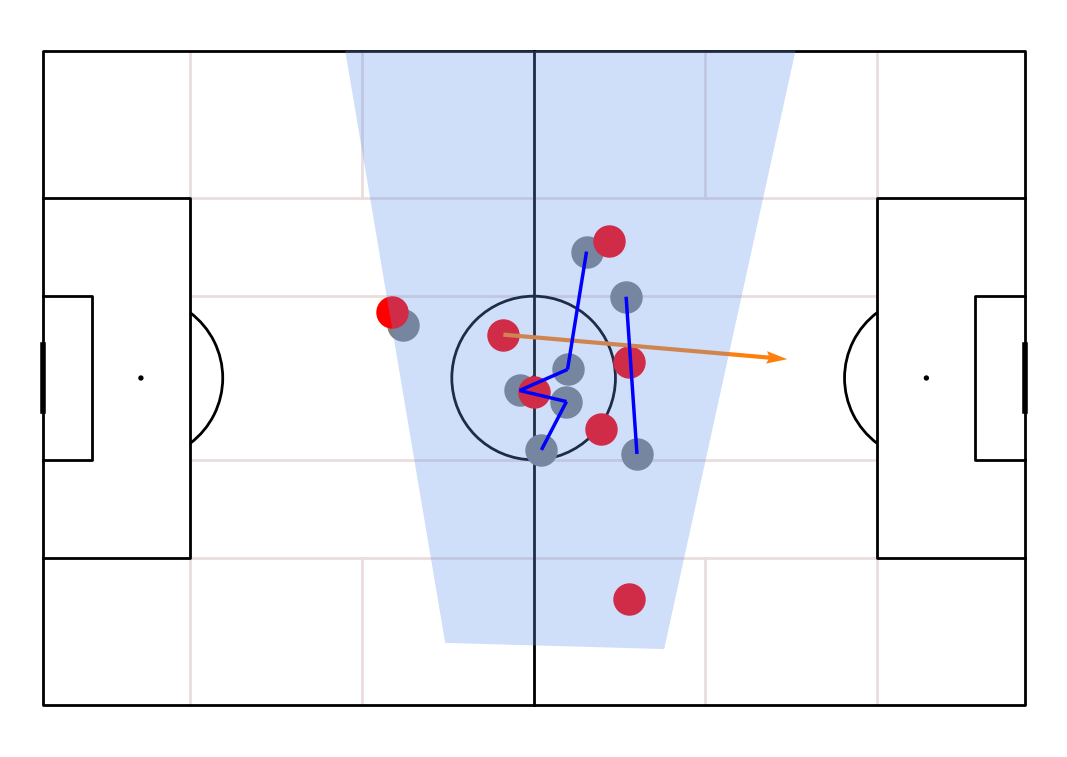

In [21]:
# index ID: 178570
# determine if it is a line-breaking pass
print(is_line_breaking(178570))
visualize_frame(178570)

### 2.3.2 Apply for the whole datast

In [22]:
# only ground passes
passes_openplay_completed = passes_openplay[passes_openplay['outcome_name'].isna()]
passes_openplay_completed = passes_openplay_completed[passes_openplay_completed['pass_height_name']=='Ground Pass']

In [23]:
# concat completed and incomplete passes
all_ground_passes = pd.concat([passes_openplay_completed, passes_openplay_incomplete])
all_ground_passes['outcome_name'].fillna('Complete', inplace=True)

In [25]:
# label line-breaking passes
all_ground_passes['line_breaking'] = all_ground_passes['index'].apply(
    is_line_breaking)

In [30]:
# temporary save for convenience
all_ground_passes[all_ground_passes['line_breaking']==True].to_csv('EURO2024_line_breaking_passes.csv', index=False)

In [2]:
# load the data to continue
LBP = pd.read_csv('EURO2024_line_breaking_passes.csv')

# 3. Analysis

1. Normalization(Per 90 min): calculate total minutes played by each player
2. Qualification: at least played 210 minutes(about 70 minutes per match if eliminated in the group stage)
3. Topics:
   - Teams:
     1. Line-Breaking Passes Attempted Per Match(v.s. Total Passes Attempted Per Match)
     2. Line-Breaking Passes Successful Rate(v.s. Line-Breaking Passes Attempted Per Match)
   - Players:
     1. Line-Breaking Passes Attempted Per 90min(v.s. Total Passes Attempted Per 90min)
     2. Line-Breaking Passes Successful Rate(v.s. Line-Breaking Passes Attempted Per 90min)
     3. Mirror Analysis: Ball Received in Space
   - Toni Kroos Breakdown
4. Will export the result into Tableau for more handy Visualizations(Scatter Plot to group teams/players into four quadrant)

## 3.1 Calculate Total Minutes Played and Get Player Position

In [3]:
# Calculate minutes played
def calculate_minutes_played(player):
    off = df_event[(df_event['player_name'] == player)
                   & (df_event['type_name'] == 'Substitution')]
    on = df_event[(df_event['substitution_replacement_name'] == player)
                  & (df_event['type_name'] == 'Substitution')]

    played_matches = df_event[df_event['player_name'] == player]['match_id'].unique()

    # Calculate minutes played when the player was subbed off
    minutes_subbed_off = off['minute'].sum()

    # Calculate minutes played when the player was subbed on
    minutes_subbed_on = 0
    for match_id in on['match_id'].unique():
        if df_event[df_event['match_id'] == match_id]['minute'].max() >= 120:
            last_event_minute = 120
        else:
            last_event_minute = 90
        sub_on_minute = on[on['match_id'] == match_id]['minute'].values[0]
        minutes_subbed_on += (last_event_minute - sub_on_minute)

    # Calculate minutes played for full matches
    full_matches = set(played_matches) - set(on['match_id']) - set(off['match_id'])
    minutes_full_matches = 0
    for match_id in full_matches:
        if df_event[df_event['match_id'] == match_id]['minute'].max() >= 120:
            last_event_minute = 120
        else:
            last_event_minute = 90
        minutes_full_matches += last_event_minute

    # Total minutes played by the player
    total_minutes_played = minutes_subbed_off + minutes_subbed_on + minutes_full_matches
    return total_minutes_played

In [11]:
# Test
players = ['Cole Palmer', 'Declan Rice', 'Jude Bellingham']
for player in players:
    total_minutes = calculate_minutes_played(player)
    print(f"Total minutes played by {player}: {total_minutes}")

Total minutes played by Cole Palmer: 149
Total minutes played by Declan Rice: 690
Total minutes played by Jude Bellingham: 670


In [12]:
# get most played position of a player throughout EURO 2024
def get_player_position(player):
    # Filter the dataframe for the given player name
    player_data = df_event[df_event['player_name'] == player]

    # Get the most frequent position played by the player
    position = player_data['position_name'].mode()[0]

    # Distinguish between 'Full Back' and 'Center Back' 
    # won't distinguish between 'Full Back' and 'Wing Back' in a 3-center-back setup
    if 'Back' in position:
        if 'Center' in position:
            position = 'Center Back'
        else:
            position = 'Full Back'
    else:
        position = position.split()[-1]
    return position

In [13]:
# Test: some tricky players' positions(e.g. Kieran Trippier, Denzel Dumfries)
players = [
    'Kieran Trippier', 'Jude Bellingham', 'Aymeric Laporte', 'Toni Kroos',
    'Harry Kane', 'Bukayo Saka', 'Denzel Dumfries'
]
for player in players:
    position = get_player_position(player)
    print(f"{player} played mostly as a {position}")

Kieran Trippier played mostly as a Full Back
Jude Bellingham played mostly as a Midfield
Aymeric Laporte played mostly as a Center Back
Toni Kroos played mostly as a Midfield
Harry Kane played mostly as a Forward
Bukayo Saka played mostly as a Wing
Denzel Dumfries played mostly as a Full Back


In [14]:
# Label the outcome 0/1 for sum up
LBP['outcome'] = LBP['outcome_name'].apply(lambda x: 1 if x == 'Complete' else 0)

## 3.2 Teams LBP Performance

In [15]:
# Calculate the number of passes for each team
team_all_passes = passes_openplay.groupby('team_name', as_index=False).agg({
    'index': 'count'
})
team_all_passes.rename(columns={'index': 'Total Passes'}, inplace=True)

In [17]:
# LBP Attempted
team_LBP = LBP.groupby('team_name', as_index=False).agg({'index':'count','outcome':'sum','match_id':'nunique'})
team_LBP.rename(columns={'index': 'LBP Attempts', 'outcome': 'Successful LBP', 'match_id': 'Matches'}, inplace=True)
# merge with total passes
team_LBP = team_LBP.merge(team_all_passes, how='inner', on='team_name')
team_LBP['Success Rate'] = np.round(
    team_LBP['Successful LBP'] / team_LBP['LBP Attempts'], 2)*100
team_LBP['LBP Attempt per Match'] = np.round(
    team_LBP['LBP Attempts'] / team_LBP['Matches'], 1)
team_LBP['Pass Per Match'] = np.round(
    team_LBP['Total Passes'] / team_LBP['Matches'], 0)
team_LBP.sort_values('LBP Attempt per Match', ascending=False).reset_index(drop=True)

,team_name,LBP Attempts,Successful LBP,Matches,Total Passes,Success Rate,LBP Attempt per Match,Pass Per Match
0,Netherlands,122,108,6,2629,89.0,20.3,438.0
1,Germany,99,87,5,2933,88.0,19.8,587.0
2,Switzerland,97,83,5,2100,86.0,19.4,420.0
3,Austria,77,63,4,1681,82.0,19.2,420.0
4,Spain,127,111,7,3712,87.0,18.1,530.0
5,Portugal,89,75,5,3346,84.0,17.8,669.0
6,Italy,62,49,4,2155,79.0,15.5,539.0
7,Ukraine,45,39,3,1236,87.0,15.0,412.0
8,Croatia,44,36,3,1551,82.0,14.7,517.0
9,Belgium,55,47,4,1823,85.0,13.8,456.0


## 3.3 Players LBP Performance

In [19]:
player_LBP = LBP.groupby('player_name', as_index=False).agg({
    'index':
    'count',
    'outcome':
    'sum'
})
player_LBP.rename(columns={
    'index': 'LBP Attempts',
    'outcome': 'Successful LBP'
},
                  inplace=True)

In [20]:
player_all_passes = passes_openplay.groupby(['player_name','team_name'],as_index=False).agg({'index':'count'})
player_all_passes.rename(columns={'index':'Total Passes'}, inplace=True)

In [21]:
# merge with total passes
player_LBP = player_all_passes.merge(player_LBP, how='left', on='player_name')
player_LBP['minutes_played'] = player_LBP['player_name'].apply(calculate_minutes_played)
player_LBP['position'] = player_LBP['player_name'].apply(get_player_position)
player_LBP['LBP Attempted per90'] = np.round(90 * player_LBP['LBP Attempts'] / player_LBP['minutes_played'], 1)
player_LBP['LBP Success Rate'] = np.round(player_LBP['Successful LBP'] / player_LBP['LBP Attempts'], 2)*100

In [26]:
player_LBP['Passes per90'] = np.round(90 * player_LBP['Total Passes'] / player_LBP['minutes_played'], 0)

In [22]:
player_LBP.fillna(0, inplace=True)

In [27]:
player_LBP[player_LBP['minutes_played'] >= 210].sort_values(
    'LBP Attempted per90', ascending=False).reset_index(drop=True).head(20)

,player_name,team_name,Total Passes,LBP Attempts,Successful LBP,minutes_played,position,LBP Attempted per90,LBP Success Rate,Passes per90
0,Toni Kroos,Germany,451,33.0,30.0,470,Midfield,6.3,91.0,86.0
1,Jorge Luiz Frello Filho,Italy,220,12.0,11.0,215,Midfield,5.0,92.0,92.0
2,Jerdy Schouten,Netherlands,296,27.0,24.0,500,Midfield,4.9,89.0,53.0
3,Manuel Obafemi Akanji,Switzerland,264,23.0,20.0,480,Center Back,4.3,87.0,50.0
4,José Ignacio Fernández Iglesias,Spain,117,12.0,10.0,263,Center Back,4.1,83.0,40.0
5,Jannik Vestergaard,Denmark,223,16.0,14.0,360,Center Back,4.0,88.0,56.0
6,Bruno Miguel Borges Fernandes,Portugal,244,16.0,12.0,373,Midfield,3.9,75.0,59.0
7,Granit Xhaka,Switzerland,349,21.0,20.0,480,Midfield,3.9,95.0,65.0
8,Aymeric Laporte,Spain,422,23.0,22.0,525,Center Back,3.9,96.0,72.0
9,Tijjani Reijnders,Netherlands,250,20.0,19.0,496,Midfield,3.6,95.0,45.0


## 3.4 Ball Received in Space

In [106]:
LBP_received = LBP.groupby('pass_recipient_name',
                           as_index=False).agg({'outcome': 'sum'})
LBP_received.rename(columns={'outcome': 'LBP Received'}, inplace=True)

In [108]:
LBP_received['minutes_played'] = LBP_received['pass_recipient_name'].apply(
    calculate_minutes_played)
LBP_received['position'] = LBP_received['pass_recipient_name'].apply(
    get_player_position)
LBP_received['LBP_Received_per90'] = np.round(
    90 * LBP_received['LBP Received'] / LBP_received['minutes_played'], 2)

In [109]:
LBP_received[LBP_received['minutes_played'] >= 210].sort_values(
    'LBP_Received_per90', ascending=False).reset_index(drop=True).head(20)

,pass_recipient_name,LBP Received,minutes_played,position,LBP_Received_per90
0,Christoph Baumgartner,17,287,Midfield,5.33
1,Memphis Depay,26,459,Forward,5.10
2,Xavi Simons,25,457,Midfield,4.92
3,İlkay Gündoğan,19,383,Midfield,4.46
4,Andrej Kramarić,12,243,Wing,4.44
5,Breel-Donald Embolo,13,298,Forward,3.93
6,Jamal Musiala,18,419,Wing,3.87
7,Florian Wirtz,12,279,Wing,3.87
8,Gianluca Scamacca,10,250,Forward,3.60
9,Álvaro Borja Morata Martín,18,451,Forward,3.59


In [110]:
# merge with LBP attempts
player_LBP = player_LBP.merge(LBP_received[['pass_recipient_name', 'LBP Received', 'LBP_Received_per90']], how='left', left_on='player_name', right_on='pass_recipient_name')

In [114]:
player_LBP.drop('pass_recipient_name', axis=1, inplace=True)
player_LBP.fillna(0, inplace=True)

In [115]:
player_LBP.to_csv('EURO2024_player_LBP.csv', index=False)

## 3.5 Toni Kroos Break down

In [80]:
kroos_LBP = LBP[(LBP['player_name']=='Toni Kroos') & (LBP['outcome_name']=='Complete')]

In [81]:
kroos_LBP.groupby('pass_recipient_name', as_index=False).agg({'match_id':'count'}).sort_values('match_id', ascending=False).reset_index(drop=True)

,pass_recipient_name,match_id
0,İlkay Gündoğan,11
1,Jamal Musiala,7
2,Florian Wirtz,5
3,Leroy Sané,2
4,Joshua Kimmich,1
5,Kai Havertz,1
6,Maximilian Mittelstädt,1
7,Niclas Füllkrug,1
8,Robert Andrich,1


Toni Kroos: Deep Lying Playmaker


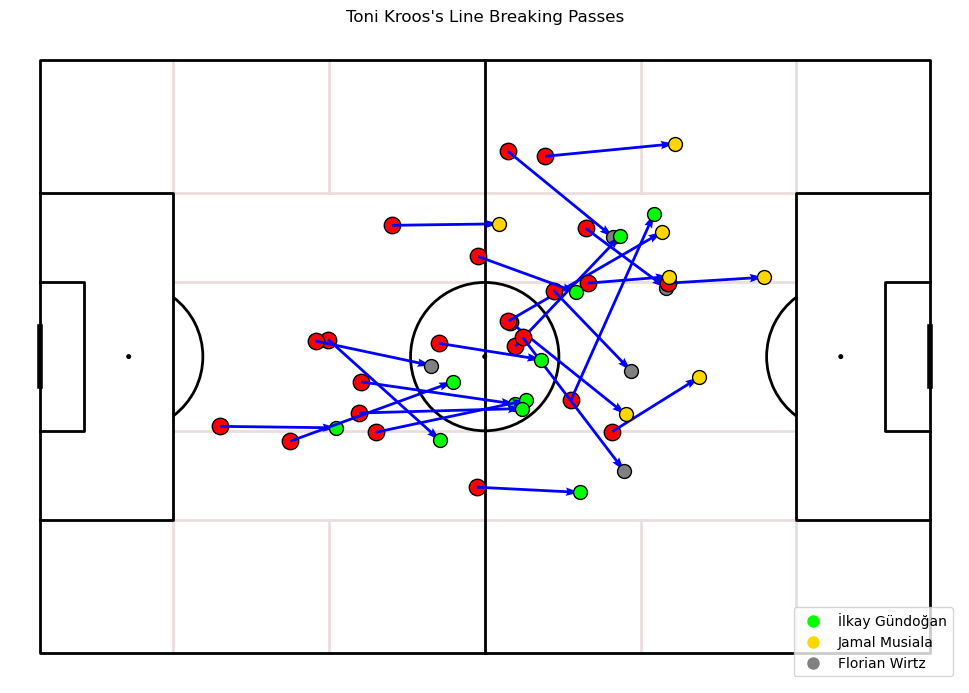

In [89]:
# Create a pitch
pitch = Pitch('statsbomb',
                    line_color='black',
                    positional=True,
                    positional_color='#eadddd',
                    shade_color='#f2f2f2')

# Plot the passes
fig, ax = pitch.draw(figsize=(10, 7))

# Adjust the color to make it clear to see
for i, row in kroos_LBP.iterrows():
    # pitch.arrows(row['x'], row['y'], row['end_x'], row['end_y'], width=2, headwidth=3, color='blue', ax=ax)
    # pitch.scatter(row['x'], row['y'], s=120, color='red', edgecolor='black', ax=ax)

    # Mark the end points with different colors based on the recipient
    if row['pass_recipient_name'] == 'İlkay Gündoğan':
        pitch.scatter(row['x'],
                      row['y'],
                      s=140,
                      color='red',
                      edgecolor='black',
                      ax=ax)
        pitch.arrows(row['x'],
                     row['y'],
                     row['end_x'],
                     row['end_y'],
                     width=2,
                     headwidth=3,
                     color='blue',
                     ax=ax)
        pitch.scatter(row['end_x'], row['end_y'], s=100, color='lime', edgecolor='black', ax=ax)
    elif row['pass_recipient_name'] == 'Jamal Musiala':
        pitch.scatter(row['x'],
                      row['y'],
                      s=140,
                      color='red',
                      edgecolor='black',
                      ax=ax)
        pitch.arrows(row['x'],
                     row['y'],
                     row['end_x'],
                     row['end_y'],
                     width=2,
                     headwidth=3,
                     color='blue',
                     ax=ax)
        pitch.scatter(row['end_x'], row['end_y'], s=100, color='gold', edgecolor='black', ax=ax)
    elif row['pass_recipient_name'] == 'Florian Wirtz':
        pitch.scatter(row['x'],
                      row['y'],
                      s=140,
                      color='red',
                      edgecolor='black',
                      ax=ax)
        pitch.arrows(row['x'],
                     row['y'],
                     row['end_x'],
                     row['end_y'],
                     width=2,
                     headwidth=3,
                     color='blue',
                     ax=ax)
        pitch.scatter(row['end_x'], row['end_y'], s=100, color='gray', edgecolor='black', ax=ax)
        # Add color legends for the three recipient names
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', label='İlkay Gündoğan', markerfacecolor='lime', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', label='Jamal Musiala', markerfacecolor='gold', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', label='Florian Wirtz', markerfacecolor='gray', markersize=10)
        ]
        ax.legend(handles=legend_elements, loc='lower right')
plt.title("Toni Kroos's Line Breaking Passes")
plt.show()